# Initial data visualization on NA web traffic

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
raw_data = pd.read_excel(ts_file)
raw_data = raw_data.copy(deep=False)

In [3]:
raw_data.head()

,Date,Device Category,Hostname,Default Channel Grouping,Sessions,Pageviews
0,2016-11-30,desktop,www.newbalance.com,(Other),5282,25091
1,2016-11-30,desktop,www.newbalance.com,Direct,22450,101023
2,2016-11-30,desktop,www.newbalance.com,Display,7923,63387
3,2016-11-30,desktop,www.newbalance.com,Organic Search,17167,121492
4,2016-11-30,desktop,www.newbalance.com,Paid Search,8584,69990


In [4]:
raw_data['Hostname'].value_counts()

Hostname
www.newbalance.com                       42076
www.nbls.cc                                 52
www.newbalance.com.googleweblight.com       12
www.hotspotshield.com                        1
Name: count, dtype: int64

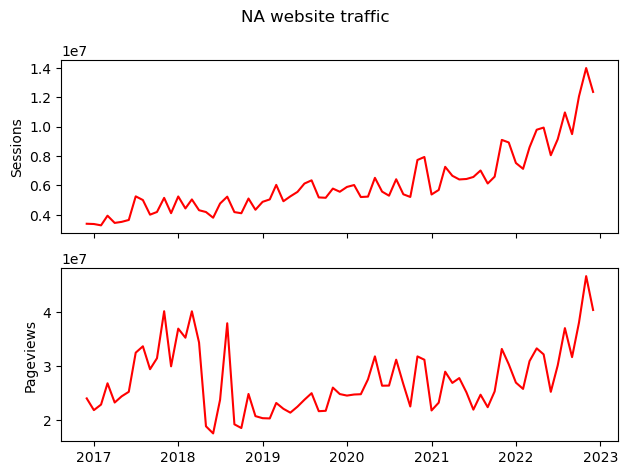

In [5]:
raw_data['Year'] = raw_data['Date'].dt.year
raw_data['Month'] = raw_data['Date'].dt.month
raw_data['Day'] = 1
raw_data['new_date'] = pd.to_datetime(raw_data[['Year', 'Month', 'Day']])

na_data = raw_data[raw_data['Hostname']=='www.newbalance.com']
na_data = na_data[na_data['Date'] > datetime(2016, 11, 30)]
na_asc_month = na_data.groupby('new_date').agg({'Sessions':'sum', 'Pageviews':'sum'})
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(na_asc_month['Sessions'], c='red')
ax1.set_ylabel('Sessions')
ax2.plot(na_asc_month['Pageviews'], c='red')
ax2.set_ylabel('Pageviews')
fig.suptitle('NA website traffic')
fig.tight_layout()
plt.show()

# Plans for experimentation phase:
- Sessions:
    - Latent factors are influencing the trend. The data doesn't look stationary
    - The data seems not to have a strong seasonality component
- Pageviews:
    - The data looks more stationary than sessions
    - The data doesn't seem to have a strong seasonality component
- Both trend and sessions trends have certain amount of noise, they need smoothing
- There is a certain correlation between pageviews and sessions
- We have 25+ websites and 2 metrics to model, so there's need to think about scaling the approach we choose

# Smoothing time series by moving average with two sigma error

## sessions

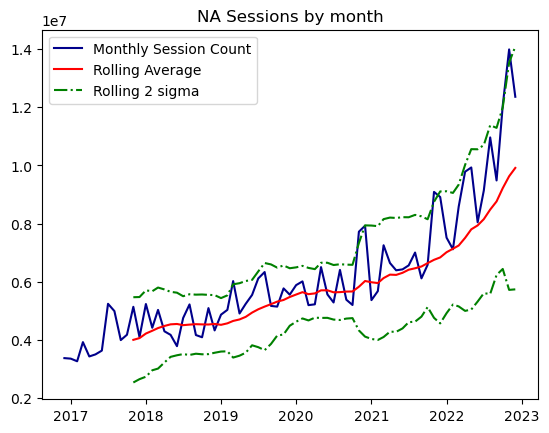

In [6]:
# rolling mean usage: https://www.statology.org/rolling-mean-pandas/
session_rolling_average = na_asc_month['Sessions'].rolling(12, center=False).mean()
session_rolling_std = na_asc_month['Sessions'].rolling(12, center=False).std()

plt.plot(na_asc_month['Sessions'], c='darkblue', label='Monthly Session Count')
plt.plot(session_rolling_average, c='red', label='Rolling Average')
plt.plot(session_rolling_average + (2 * session_rolling_std), c='green', linestyle='-.', label='Rolling 2 sigma')
plt.plot(session_rolling_average - (2 * session_rolling_std), c='green', linestyle='-.')
plt.legend(loc='best')
plt.title('NA Sessions by month')
plt.show(block=False)

- A small step function occurs around 2022
- The stddev varies widely during different time periods. After 2020, the variance becomes much broader than it had been historically
- There will be potential problems from training and validation datasets that don't reflect the trend change
- If we train up to the year 2020 and expect a model will accurately predict from 2020 to 2022, that will be impossible

## pageviews

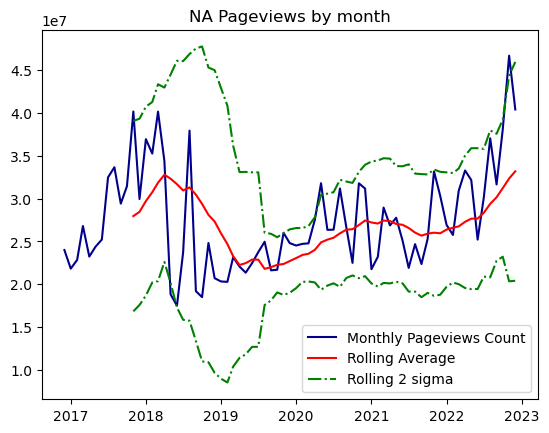

In [7]:
session_rolling_average = na_asc_month['Pageviews'].rolling(12, center=False).mean()
session_rolling_std = na_asc_month['Pageviews'].rolling(12, center=False).std()

plt.plot(na_asc_month['Pageviews'], c='darkblue', label='Monthly Pageviews Count')
plt.plot(session_rolling_average, c='red', label='Rolling Average')
plt.plot(session_rolling_average + (2 * session_rolling_std), c='green', linestyle='-.', label='Rolling 2 sigma')
plt.plot(session_rolling_average - (2 * session_rolling_std), c='green', linestyle='-.')
plt.legend(loc='best')
plt.title('NA Pageviews by month')
plt.show(block=False)

- No obvious step function could be observed
- The stddev also varies widely during different time periods. Before 2020, the variance was much broader than it was in 2020, and after 2020, it gradually becomes wider
- There will be similar problems from preparing training and validation datasets that don't reflect the trend change

# Dickey-Fuller stationary test
- Certain models will struggle with predicting a nonstationary trend
- This test will inform us of whether we need to provide stationary adjustments to the time series for particular models that are incapable of handling nonstationary data
- If the test comes back with a value indicating that the time series is stationary, then essentially all models can use the raw data with no transformations applied to it. However, if it's not, extra work will be required

## sessions
- test statistic value is larger (even positive) than all given critical values, so this time series is not stationary
- use #lags from adfuller report for seasonality period in decomposition
- set period=12 in decomposiyion, we got a smoother trend than the trend decomposed by period value of 11, but both residuals seem to have some signals

In [8]:
dickey_fuller_test = adfuller(na_asc_month['Sessions'], autolag='AIC')
test_items = dickey_fuller_test[:4]
report_items = test_items + (("not " if test_items[1] > 0.05 else "") + "stationary",)

In [9]:
df_report = pd.Series(report_items, index=['Test Statistic', 'p-value', '# Lags', '# Observations', 'Stationary Test'])
for k, v in dickey_fuller_test[4].items():
    df_report['Critical Value(%s)' % k] = v
print(df_report)

Test Statistic               3.637495
p-value                           1.0
# Lags                             11
# Observations                     61
Stationary Test        not stationary
Critical Value(1%)          -3.542413
Critical Value(5%)          -2.910236
Critical Value(10%)         -2.592745
dtype: object


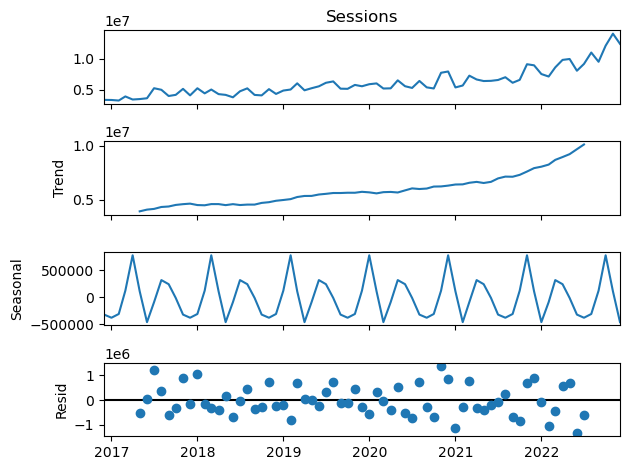

In [10]:
decomposed_trends = seasonal_decompose(na_asc_month['Sessions'], period=11)
trend_plot = decomposed_trends.plot()
plt.savefig('sessions_decomposed11.svg', format='svg')

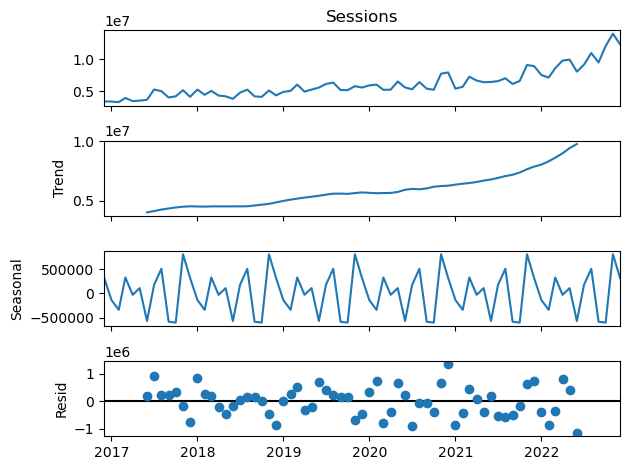

In [11]:
decomposed_trends = seasonal_decompose(na_asc_month['Sessions'], period=12)
trend_plot = decomposed_trends.plot()
plt.savefig('sessions_decomposed12.svg', format='svg')

## pageviews
- test statistic value is larger than all given critical values, so this time series is not stationary
- set period=12 in decomposiyion, we got a smoother trend than the trend decomposed by period value of 2, but both residuals seem to have some signals

In [12]:
dickey_fuller_test = adfuller(na_asc_month['Pageviews'], autolag='AIC')
test_items = dickey_fuller_test[:4]
report_items = test_items + (("not " if test_items[1] > 0.05 else "") + "stationary",)

df_report = pd.Series(report_items, index=['Test Statistic', 'p-value', '# Lags', '# Observations', 'Stationary Test'])
for k, v in dickey_fuller_test[4].items():
    df_report['Critical Value(%s)' % k] = v
print(df_report)

Test Statistic              -1.679978
p-value                      0.441457
# Lags                              2
# Observations                     70
Stationary Test        not stationary
Critical Value(1%)          -3.527426
Critical Value(5%)          -2.903811
Critical Value(10%)          -2.58932
dtype: object


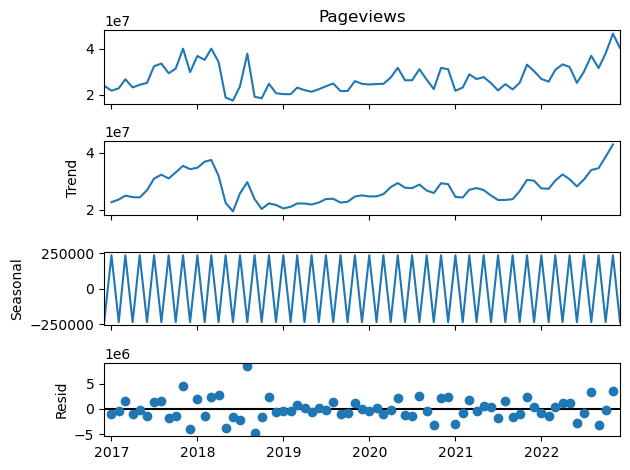

In [13]:
decomposed_trends = seasonal_decompose(na_asc_month['Pageviews'], period=2)
trend_plot = decomposed_trends.plot()
plt.savefig('pageviews_decomposed2.svg', format='svg')

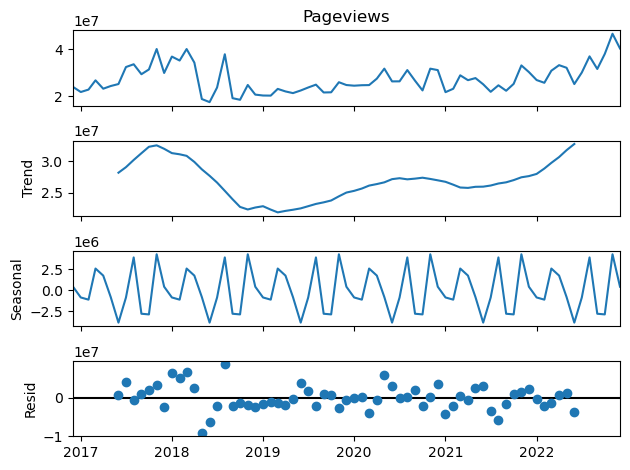

In [14]:
decomposed_trends = seasonal_decompose(na_asc_month['Pageviews'], period=12)
trend_plot = decomposed_trends.plot()
plt.savefig('pageviews_decomposed12.svg', format='svg')

# Time-series differencing

## sessions
- The trend looks abnormal in Jan 2021, it stands out in NA sessions logdiff=1
- A continuous surge occurs after the drop in sessions, it stands out in NA sessions logdiff=12

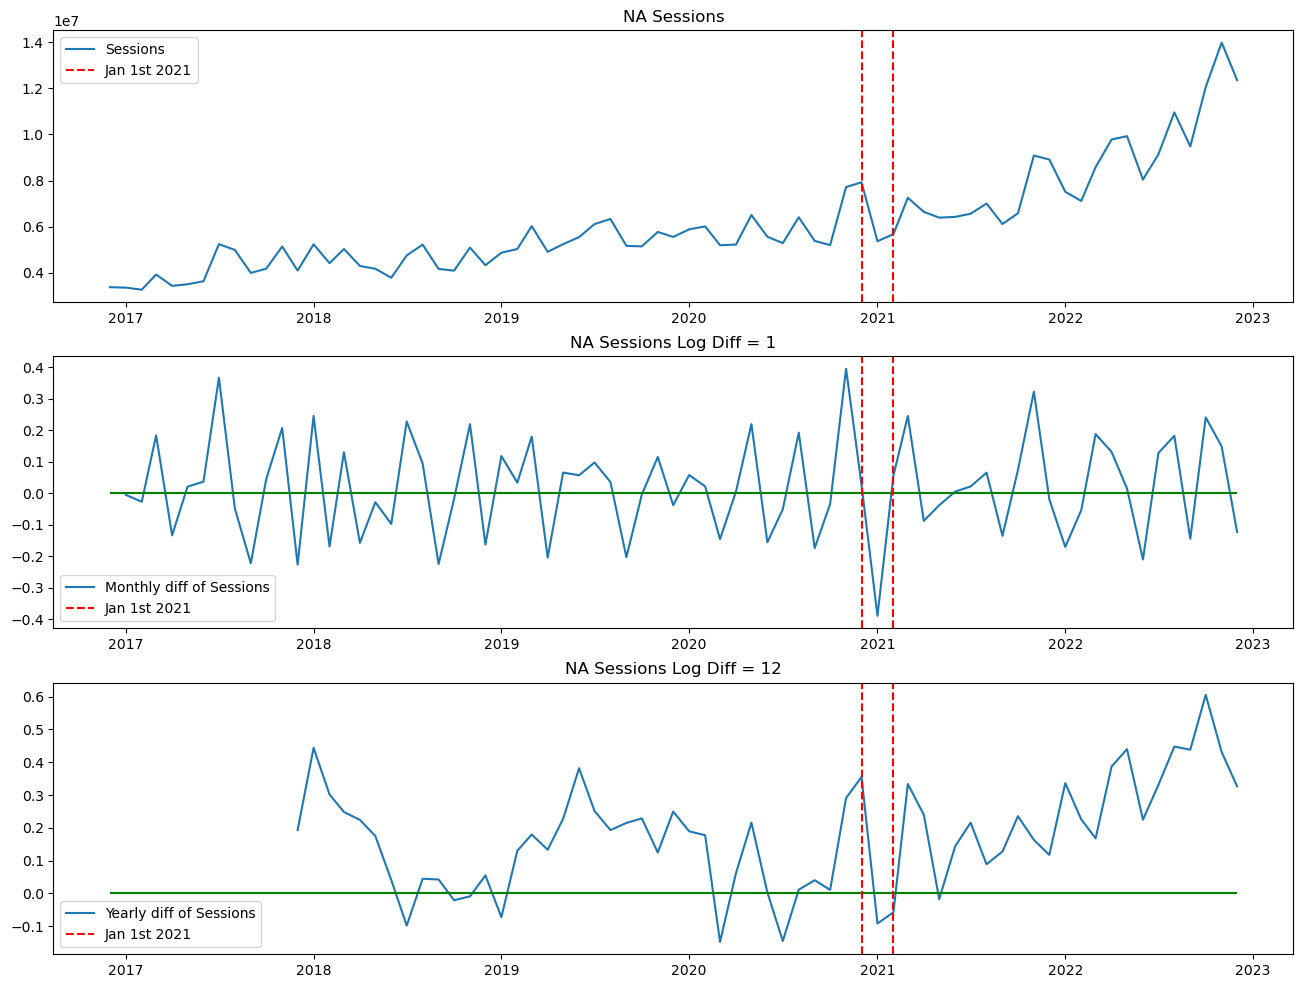

In [15]:
na_asc_month['Log Sessions'] = np.log(na_asc_month['Sessions'])
na_asc_month['DiffLog Sessions month'] = na_asc_month['Log Sessions'].diff(1)
na_asc_month['DiffLog Sessions year'] = na_asc_month['Log Sessions'].diff(12)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
boundary1 = datetime.strptime('2020-12-01', '%Y-%m-%d')
boundary2 = datetime.strptime('2021-02-01', '%Y-%m-%d')
axes[0].plot(na_asc_month['Sessions'], '-', label='Sessions')
axes[0].set(title='NA Sessions')
axes[0].axvline(boundary1, 0, 5e7, color='red', linestyle='--', label='Jan 1st 2021')
axes[0].axvline(boundary2, 0, 5e7, color='red', linestyle='--')
axes[0].legend(loc='upper left')

axes[1].plot(na_asc_month['DiffLog Sessions month'], '-', label='Monthly diff of Sessions')
axes[1].hlines(0, na_asc_month.index[0], na_asc_month.index[-1], 'g')
axes[1].set(title='NA Sessions Log Diff = 1')
axes[1].axvline(boundary1, 0, 5e7, color='red', linestyle='--', label='Jan 1st 2021')
axes[1].axvline(boundary2, 0, 5e7, color='red', linestyle='--')
axes[1].legend(loc='lower left')

axes[2].plot(na_asc_month['DiffLog Sessions year'], '-', label='Yearly diff of Sessions')
axes[2].hlines(0, na_asc_month.index[0], na_asc_month.index[-1], 'g')
axes[2].set(title='NA Sessions Log Diff = 12')
axes[2].axvline(boundary1, 0, 5e7, color='red', linestyle='--', label='Jan 1st 2021')
axes[2].axvline(boundary2, 0, 5e7, color='red', linestyle='--')
axes[2].legend(loc='lower left')
plt.savefig('sessions_logdiff.svg', format='svg')

## pageviews
- A huge drop, increase and then drop again happen in 4 months from NA Pageviews Logdiff=1
- From Mar 2018 to Mar 2019, the pageviews are far less than the same period 12 months ago, from NA Pageviews Logdiff=12

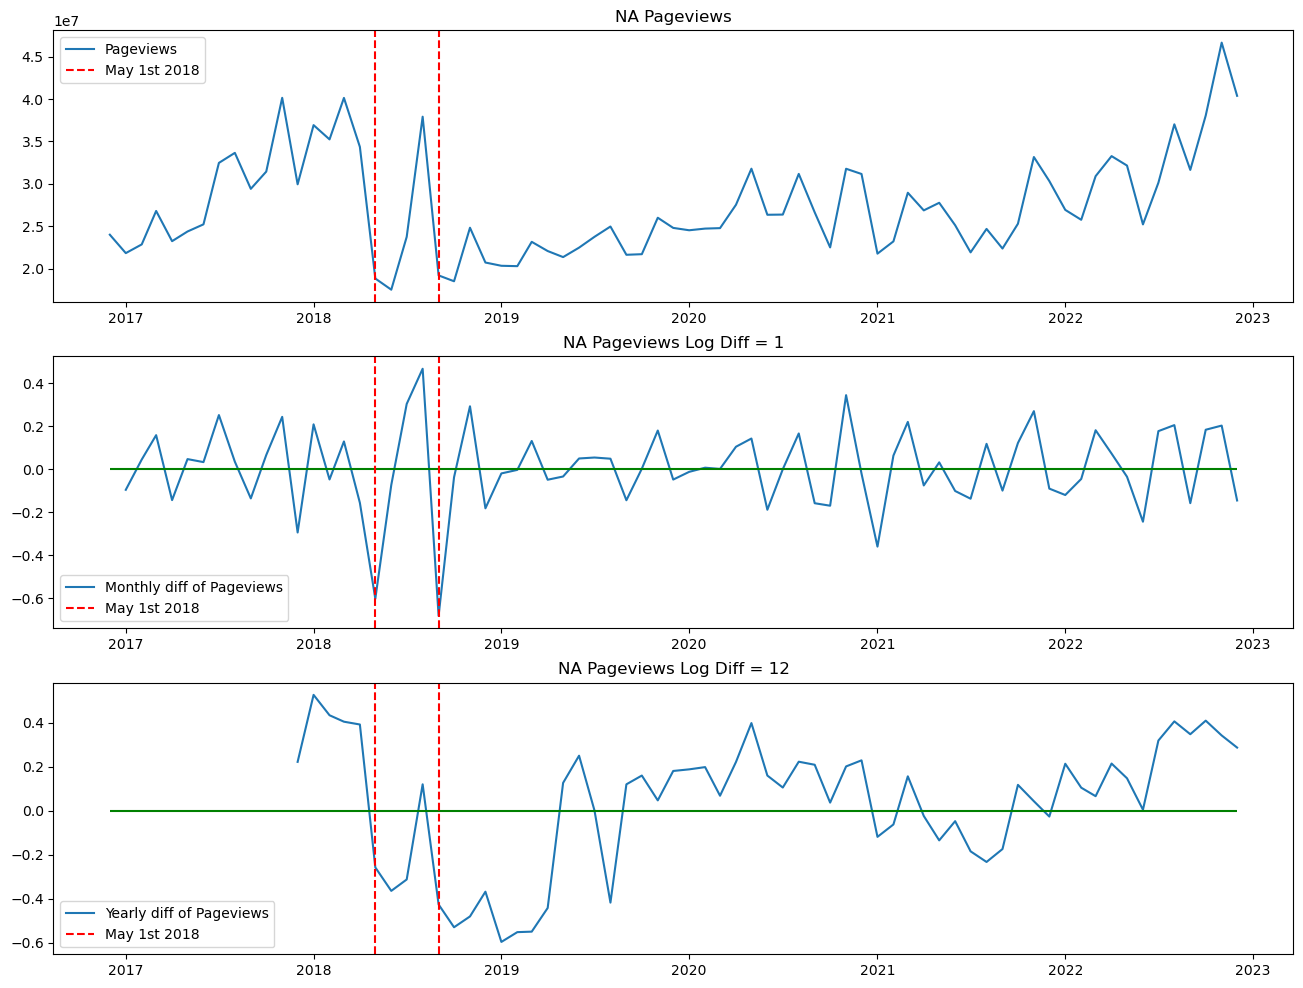

In [16]:
na_asc_month['Log Pageviews'] = np.log(na_asc_month['Pageviews'])
na_asc_month['DiffLog Pageviews month'] = na_asc_month['Log Pageviews'].diff(1)
na_asc_month['DiffLog Pageviews year'] = na_asc_month['Log Pageviews'].diff(12)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
boundary1 = datetime.strptime('2018-5-01', '%Y-%m-%d')
boundary2 = datetime.strptime('2018-9-01', '%Y-%m-%d')
axes[0].plot(na_asc_month['Pageviews'], '-', label='Pageviews')
axes[0].set(title='NA Pageviews')
axes[0].axvline(boundary1, 0, 5e7, color='red', linestyle='--', label='May 1st 2018')
axes[0].axvline(boundary2, 0, 5e7, color='red', linestyle='--')
axes[0].legend(loc='upper left')

axes[1].plot(na_asc_month['DiffLog Pageviews month'], '-', label='Monthly diff of Pageviews')
axes[1].hlines(0, na_asc_month.index[0], na_asc_month.index[-1], 'g')
axes[1].set(title='NA Pageviews Log Diff = 1')
axes[1].axvline(boundary1, 0, 5e7, color='red', linestyle='--', label='May 1st 2018')
axes[1].axvline(boundary2, 0, 5e7, color='red', linestyle='--')
axes[1].legend(loc='lower left')

axes[2].plot(na_asc_month['DiffLog Pageviews year'], '-', label='Yearly diff of Pageviews')
axes[2].hlines(0, na_asc_month.index[0], na_asc_month.index[-1], 'g')
axes[2].set(title='NA Pageviews Log Diff = 12')
axes[2].axvline(boundary1, 0, 5e7, color='red', linestyle='--', label='May 1st 2018')
axes[2].axvline(boundary2, 0, 5e7, color='red', linestyle='--')
axes[2].legend(loc='lower left')
plt.savefig('pageviews_logdiff.svg', format='svg')

# Utility Functions Setup

In [28]:
# pd.read_excel: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
# pd.DatetimeIndex: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

HOSTNAME_FIELD = 'Hostname'

def pull_raw_data(file_location):
    raw = pd.read_excel(file_location, None)
    return raw

def get_region_data(region, file_location):
    all_data = pull_raw_data(file_location)
    region_data = all_data[region]
    region_data = region_data.copy(deep=False)
    region_data.set_index('Date', inplace=True)
    return region_data
    # region_data.index = pd.DatetimeIndex(region_data.index.values, freq=region_data.index.inferred_freq)
    # asc = region_data.sort_index()
    # return asc

def get_hostname_data(hostname, region_data):
    hostname_data = region_data[region_data[HOSTNAME_FIELD] == hostname]
    return hostname_data

In [29]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
region_data = get_region_data('US', ts_file)
region_data

,Device Category,Hostname,Default Channel Grouping,Sessions,Pageviews
Date,,,,,
2016-11-30 00:00:00,desktop,www.newbalance.com,(Other),5282,25091
2016-11-30 00:00:00,desktop,www.newbalance.com,Direct,22450,101023
2016-11-30 00:00:00,desktop,www.newbalance.com,Display,7923,63387
2016-11-30 00:00:00,desktop,www.newbalance.com,Organic Search,17167,121492
2016-11-30 00:00:00,desktop,www.newbalance.com,Paid Search,8584,69990
...,...,...,...,...,...
44926,tablet,www.newbalance.com,Email,337,1123
44926,tablet,www.newbalance.com,Organic Search,1207,4687
44926,tablet,www.newbalance.com,Paid Search,982,4743


In [30]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
raw = pd.read_excel(ts_file, None)
region_data = raw['US']
region_data = region_data.copy(deep=False)

In [31]:
region_data

,Date,Device Category,Hostname,Default Channel Grouping,Sessions,Pageviews
0,2016-11-30 00:00:00,desktop,www.newbalance.com,(Other),5282,25091
1,2016-11-30 00:00:00,desktop,www.newbalance.com,Direct,22450,101023
2,2016-11-30 00:00:00,desktop,www.newbalance.com,Display,7923,63387
3,2016-11-30 00:00:00,desktop,www.newbalance.com,Organic Search,17167,121492
4,2016-11-30 00:00:00,desktop,www.newbalance.com,Paid Search,8584,69990
...,...,...,...,...,...,...
42136,44926,tablet,www.newbalance.com,Email,337,1123
42137,44926,tablet,www.newbalance.com,Organic Search,1207,4687
42138,44926,tablet,www.newbalance.com,Paid Search,982,4743
42139,44926,tablet,www.newbalance.com,Referral,84,477


In [33]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
region_data = pd.read_excel(ts_file)
region_data = region_data.copy(deep=False)
region_data

,Date,Device Category,Hostname,Default Channel Grouping,Sessions,Pageviews
0,2016-11-30 00:00:00,desktop,www.newbalance.com,(Other),5282,25091
1,2016-11-30 00:00:00,desktop,www.newbalance.com,Direct,22450,101023
2,2016-11-30 00:00:00,desktop,www.newbalance.com,Display,7923,63387
3,2016-11-30 00:00:00,desktop,www.newbalance.com,Organic Search,17167,121492
4,2016-11-30 00:00:00,desktop,www.newbalance.com,Paid Search,8584,69990
...,...,...,...,...,...,...
42136,44926,tablet,www.newbalance.com,Email,337,1123
42137,44926,tablet,www.newbalance.com,Organic Search,1207,4687
42138,44926,tablet,www.newbalance.com,Paid Search,982,4743
42139,44926,tablet,www.newbalance.com,Referral,84,477


In [ ]:
region_data['']

In [ ]:
region_data.set_index('Date', inplace=True)

In [19]:

raw_data = pd.read_excel(ts_file, None)

In [21]:
raw_data.keys()

dict_keys(['NB | GA | US Data', 'NB | GA | CA Data', 'NB | GA | AU Data', 'NB | GA | NZ Data', 'NB | GA | JNBO Data'])

In [23]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_2.xlsx'
raw_data = pd.read_excel(ts_file, None)
raw_data.keys()

dict_keys(['Sheet1', 'EU_UK', 'TW', 'HK', 'MY', 'SG'])